In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

: 

In [160]:
def generate_laplacian_pyramid(img, levels):
    gaussian_pyramid = [img]
    for i in range(levels):
        img = cv2.pyrDown(img)
        gaussian_pyramid.append(img)

    laplacian_pyramid = []  # Initialize the Laplacian pyramid
    for i in range(levels, 0, -1):
         # Expand the current Gaussian level
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])

        # Resize expanded image to match the size of the next higher level
        height, width = gaussian_pyramid[i-1].shape[:2]
        gaussian_expanded = cv2.resize(gaussian_expanded, (width, height))
        # Subtract the expanded image from the previous level
        laplacian = cv2.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)

    return laplacian_pyramid

In [161]:
def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
    # Start with the smallest level
    reconstructed_image = laplacian_pyramid[-1]

    for level in range(len(laplacian_pyramid)-2, -1, -1):
        # Expand the current level
        reconstructed_image = cv2.pyrUp(reconstructed_image)

        # Resize to ensure the same dimension as the next level up
        height, width = laplacian_pyramid[level].shape[:2]
        reconstructed_image = cv2.resize(reconstructed_image, (width, height))

        # Add the expanded image to the next level up
        reconstructed_image = cv2.add(laplacian_pyramid[level], reconstructed_image)

    return reconstructed_image

In [162]:
def generate_gaussian_pyramid(img, levels):
    gaussian_pyramid = [img]
    for i in range(levels):
        img = cv2.pyrDown(img)
        gaussian_pyramid.append(img)
    return gaussian_pyramid

def generate_laplacian_pyramid(img, levels):
    gaussian_pyramid = generate_gaussian_pyramid(img, levels)
    laplacian_pyramid = []
    for i in range(levels):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        L = cv2.subtract(gaussian_pyramid[i], cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size))
        laplacian_pyramid.append(L)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

In [163]:
def blend_pyramids(lap_pyr1, lap_pyr2, mask_pyr):
    blended_pyramid = []
    for lap1, lap2, mask in zip(lap_pyr1, lap_pyr2, mask_pyr):
        blended = lap1 * mask + lap2 * (1 - mask)
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_pyramid(laplacian_pyramid):
    image = laplacian_pyramid[-1]  # Start with the smallest level
    for level in range(len(laplacian_pyramid)-2, -1, -1):
        image = cv2.pyrUp(image)
        next_level_shape = laplacian_pyramid[level].shape
        image = cv2.resize(image, (next_level_shape[1], next_level_shape[0]))  # width, height
        image = cv2.add(image, laplacian_pyramid[level])
    return image


In [164]:
def blend_images(img1, img2, levels=6, mask=None):
    # Generate Laplacian pyramids for both images
    lap_pyr1 = generate_laplacian_pyramid(img1, levels)
    lap_pyr2 = generate_laplacian_pyramid(img2, levels)
    if mask is None:
        mask = np.ones_like(img1[:,:,0])
    mask_pyr = generate_gaussian_pyramid(mask.astype(np.float32), levels)
    mask_pyr = [mask[:,:,np.newaxis] for mask in mask_pyr]  # mask has the same number of channels

    # Blend the pyramids
    blended_pyramid = blend_pyramids(lap_pyr1, lap_pyr2, mask_pyr)

    # Reconstruct the blended image from its pyramid
    blended_image = reconstruct_from_pyramid(blended_pyramid)
    return blended_image

In [165]:
img1 = cv2.imread('/content/How-To-Convert-PDF-To-JPG-On-Windows-11-My-Final-Thoughts-1-1024x683.jpg')
img2 = cv2.imread('/content/website.jpg')

# Resize images to the same dimensions
img1 = cv2.resize(img1, (600, 400))
img2 = cv2.resize(img2, (600, 400))

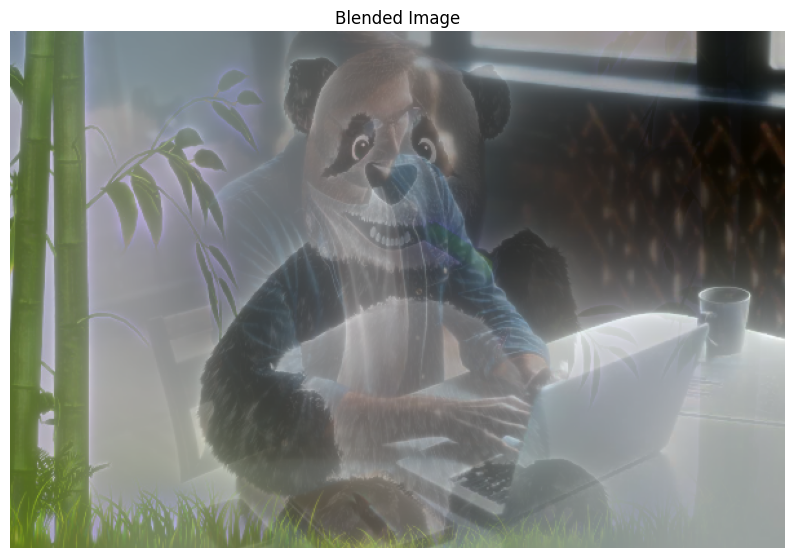

In [169]:
blended_image = blend_images(img1, img2, mask=mask)
def display_image(image, title="Image"):
    # Check if image is in color and convert from BGR to RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize image if it is not uint8
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

display_image(blended_image, "Blended Image")

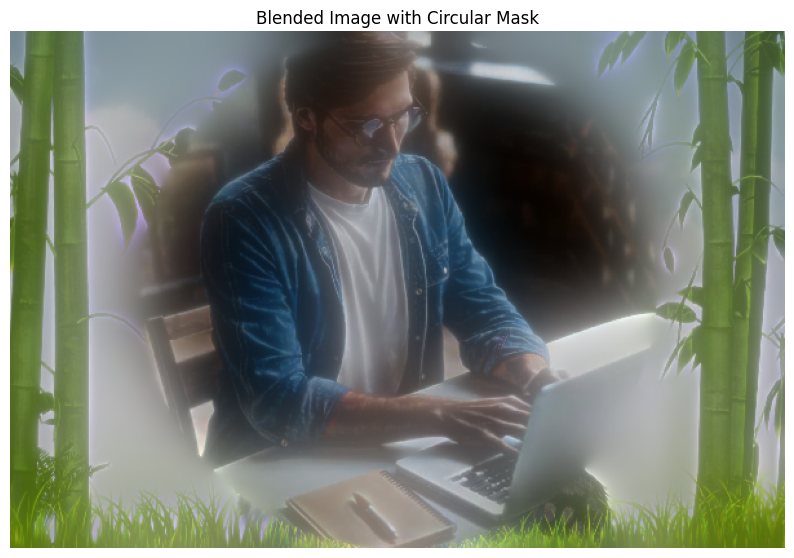

In [167]:
def create_circular_mask(height, width, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(width/2), int(height/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], width-center[0], height-center[1])

    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask.astype(float)

# Example of using a circular mask
circular_mask = create_circular_mask(400, 600)
blended_image = blend_images(img1, img2, levels=5, mask=circular_mask)
display_image(blended_image, "Blended Image with Circular Mask")

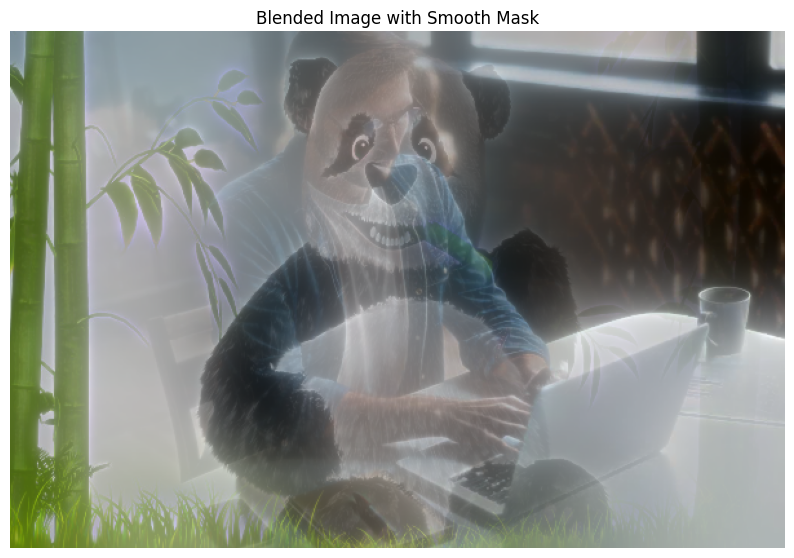

In [168]:
# Gaussian blur to the linear mask to make the transition smoother
smooth_mask = cv2.GaussianBlur(mask, (21, 21), 0)
blended_image = blend_images(img1, img2, levels=5, mask=smooth_mask)
display_image(blended_image, "Blended Image with Smooth Mask")